In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy

In [4]:
root_path = "/home/g.esposito/sc2-benchmark"
layer_confs = [file_path for file_path in os.listdir(root_path) if file_path.startswith("FSIM_W_hpc_sem_L")]

detailed_report = pd.DataFrame([])
general_report = pd.DataFrame([])

for layer_conf in layer_confs:
    configurations_log = os.path.join(root_path, layer_conf)

    # to_iterate = [log for log in os.listdir(configurations_log) if os.path.isdir(configurations_log)]
    # print(to_iterate)
    for cnf in os.listdir(configurations_log):
        cnf_path = os.path.join(configurations_log, cnf) 
        if os.path.isdir(cnf_path):
            # print(os.path.isdir(configurations_log))
            # print(cnf)
            for file in os.listdir(cnf_path):
                report_path = os.path.join(cnf_path, file)
                # print(report_path)
                if file == "Faulty_masks_report.csv":
                    report = pd.read_csv(report_path)

                    report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
                    report['bit_faulty_position'] = np.log2(report['bitmask'])

                    report.drop(columns=['Unnamed: 0'], inplace=True)
                    detailed_report = pd.concat([detailed_report, report], axis=0, ignore_index=True)

                if file == "fsim_full_report.csv":
                    report = pd.read_csv(report_path)

                    report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"

                    report['bit_faulty_position'] = np.log2(report['bitmask'])

                    indices = report.query("mask_Crit==0 and mask_SDC==0 and mask_Masked == 0").index
                    for idx in indices:
                        report.loc[idx, 'Crit_perc'] = 100
                        report.loc[idx, 'SDC_perc'] = 0
                        report.loc[idx, 'masked_perc'] = 100

                    report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)
                    # print(report.columns)

                    tot_mask_per_fault = report['mask_Crit'] + report['mask_SDC'] + report['mask_Masked']
                    # for val in tot_mask_per_fault:
                    #     if val == 0:
                    #         print('queste sono tutte critiche')
                    report['Crit_perc'] = (report['mask_Crit'] / tot_mask_per_fault)*100
                    report['SDC_perc'] = (report['mask_SDC'] / tot_mask_per_fault)*100
                    report['masked_perc'] = (report['mask_Masked'] / tot_mask_per_fault)*100

                    report['global_fault_f1@1'] = report['global_fault_f1@1']*100

                    general_report = pd.concat([general_report, report], axis=0, ignore_index=True)
                

detailed_report.columns
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask',
       'global_gold_acc', 'global_gold_f1@1', 'global_fault_acc',
       'global_fault_f1@1', 'mask_Crit', 'mask_SDC', 'mask_Masked', 'Layer',
       'Ffree_Weight', 'Faulty_weight', 'Abs_error', 'conf_detail',
       'bit_faulty_position', 'Crit_perc', 'SDC_perc', 'masked_perc'],
      dtype='object')

In [5]:
# Define the desired order of the categories
desired_order = ['cnf1', 'cnf2', 'cnf3', 'cnf6', 'cnf9', 'cnf12', 'teacher_cnf']

# Sort the data by the categorical variable
detailed_report = detailed_report.sort_values(by='conf_detail')
detailed_report['conf_detail'] = detailed_report['conf_detail'].astype('category')
detailed_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)

<ipython-input-5-44b429b3d5fc>:7: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  detailed_report['conf_detail'].cat.reorder_categories(desired_order, inplace=True)


## Labels difference

/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Probability that, considering only sdc and critical boxes, the golden labels are not predicted also by the faulty model')

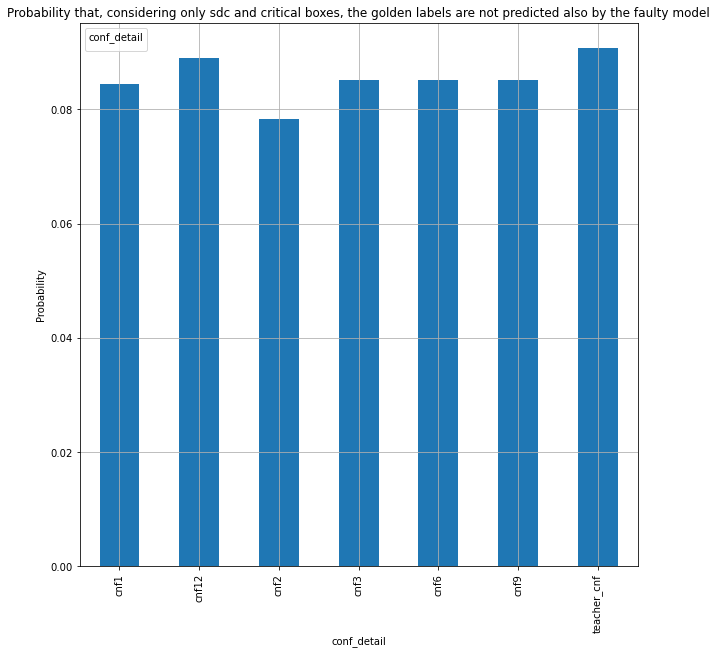

In [6]:
general_report['SDC_Crit_masks'] = general_report['mask_Crit'] + general_report['mask_SDC'] + general_report['mask_Masked']
new_grouped_df = general_report.groupby('conf_detail').sum().unstack()['SDC_Crit_masks']

detailed_report['expected_label'] = False
f_surclasses_idxs = detailed_report.query("f_label_area.isnull() and not g_label_area.isnull()").index
detailed_report['expected_label'].loc[f_surclasses_idxs] = True
new_df = detailed_report.loc[f_surclasses_idxs]
grouped = new_df[new_df['expected_label']].groupby('conf_detail').size()

percentage_groups = grouped/new_grouped_df

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('configuration')
ax.set_ylabel('Probability')
ax.legend(title='conf_detail')
# ax.set_xticklabels([1,2,3,4],rotation=90)
percentage_groups.plot(kind='bar', ax = ax, grid=True)
plt.title('Probability that, considering only sdc and critical boxes, the golden labels are not predicted also by the faulty model')

In [7]:
general_report['SDC_Crit_masks'] = general_report['mask_Crit'] + general_report['mask_SDC'] + general_report['mask_Masked']
new_grouped_df = general_report.groupby('conf_detail').sum()['SDC_Crit_masks']

detailed_report['expected_label'] = False
g_surclasses = detailed_report.query("g_label_area.isnull() and not f_label_area.isnull()")
grouped = g_surclasses.groupby('conf_detail').size()

new_percentage_groups = grouped/new_grouped_df

Text(0.5, 1.0, 'Probability that, considering only sdc and critical labels, the faulty labels are not expected also by the golden model')

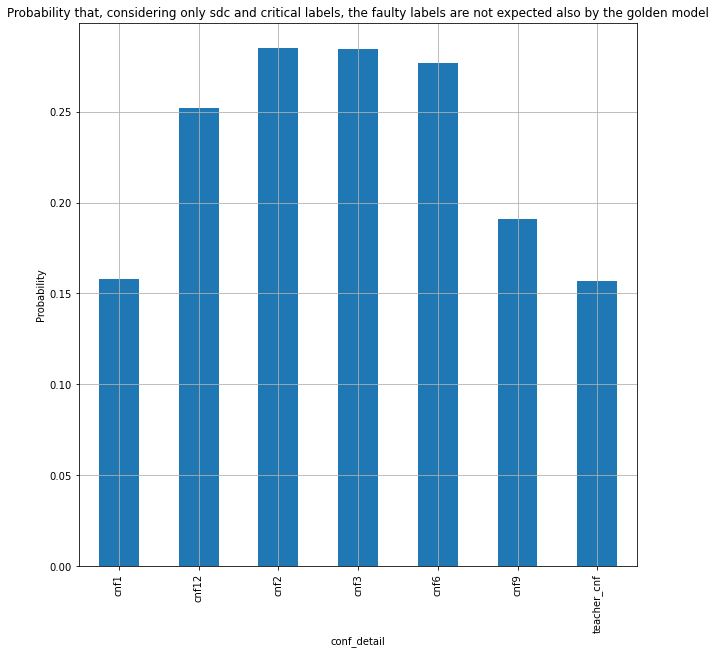

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('configuration')
ax.set_ylabel('Probability')
# ax.legend(title='conf_detail')
# ax.set_xticklabels([1,2,3,4],rotation=90)
new_percentage_groups.plot(kind='bar', ax = ax, grid=True)
plt.title('Probability that, considering only sdc and critical labels, the faulty labels are not expected also by the golden model')

In [9]:
print(f'Percentage of critical masks because of the low iou score: {len(detailed_report.query("f_label_acc < 100 and not f_label_acc.isnull()"))/len(detailed_report)}')

Percentage of critical masks because of the low iou score: 0.8522786068280176


## Area Ratio 

In [10]:
detailed_report['area_ratio'] = detailed_report['f_label_area'] / detailed_report['g_label_area']*100

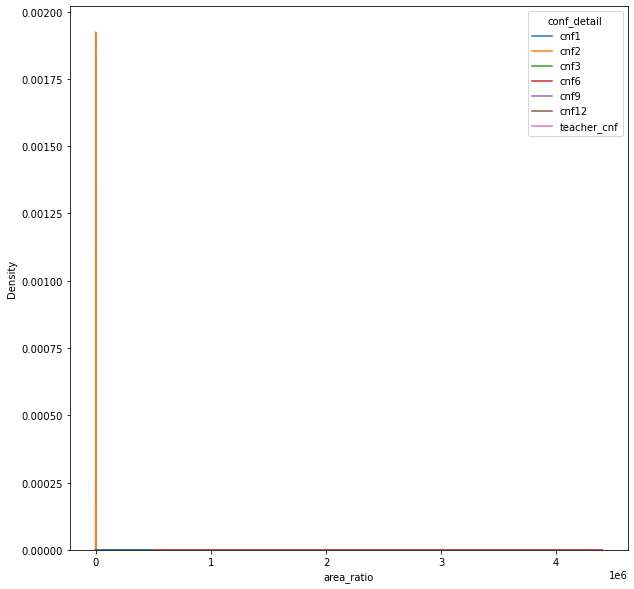

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=detailed_report, x= 'area_ratio', hue='conf_detail', palette="tab10")

In [17]:
area_ratio_by = detailed_report[detailed_report['area_ratio']>200].groupby(by='conf_detail').size()
area_ratio_by = area_ratio_by/new_grouped_df

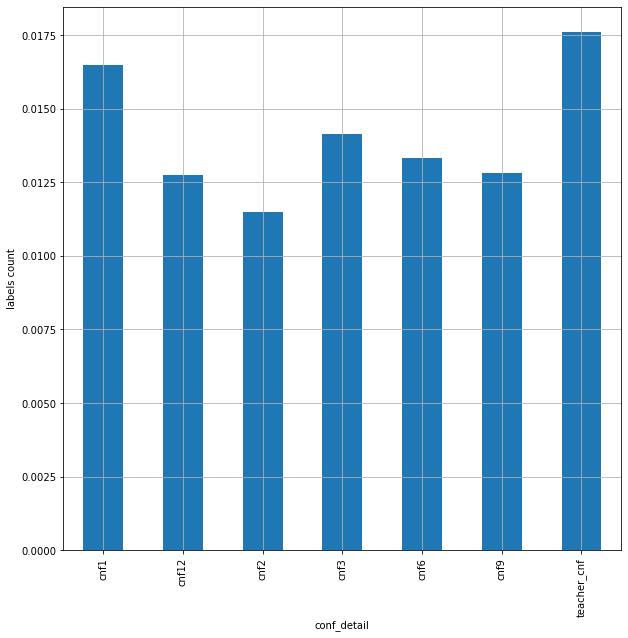

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('configuration')
ax.set_ylabel('labels count')
# ax.set_xticklabels([1,2,3,4],rotation=90)
area_ratio_by.plot(kind='bar', ax = ax, grid=True)

In [46]:
print(f"number of labels whose area is the double of the fault free model: {len(detailed_report[detailed_report['area_ratio']>200])}")
print(f"which represents the {(len(detailed_report[detailed_report['area_ratio']>200]) / len(detailed_report))*100}% of the total sdc and critical labels")

number of labels whose area is the double of the fault free model: 23054
which represents the 0.5674671529217395% of the total sdc and critical labels


### Cutting off these outliers let us see the distribution

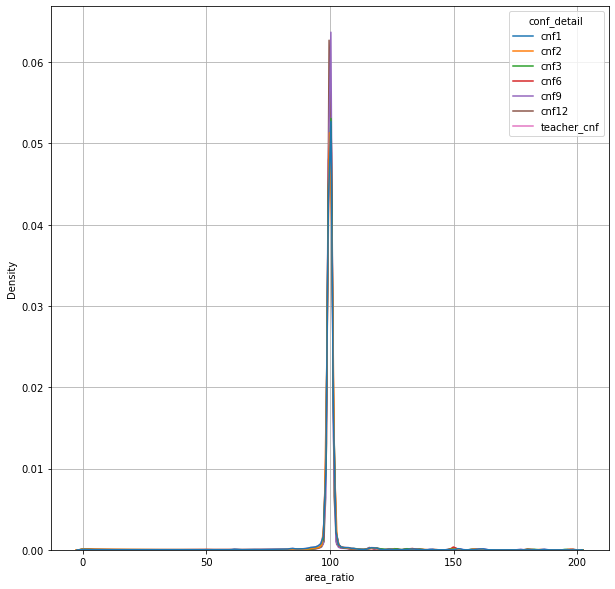

In [14]:
normal_area = detailed_report[detailed_report['area_ratio']<200]
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax, data=normal_area, x= 'area_ratio', hue='conf_detail', palette="tab10")
ax.grid()

In [66]:
detailed_report.columns

Index(['FaultID', 'imID', 'layer', 'kernel', 'channel', 'row', 'col',
       'bitmask', 'label_idx', 'f_class_iou', 'f_label_acc', 'f_label_area',
       'f_label_f1', 'g_class_iou', 'g_label_acc', 'g_label_area',
       'g_label_f1', 'iou_per_img', 'conf_detail', 'bit_faulty_position',
       'expected_label'],
      dtype='object')

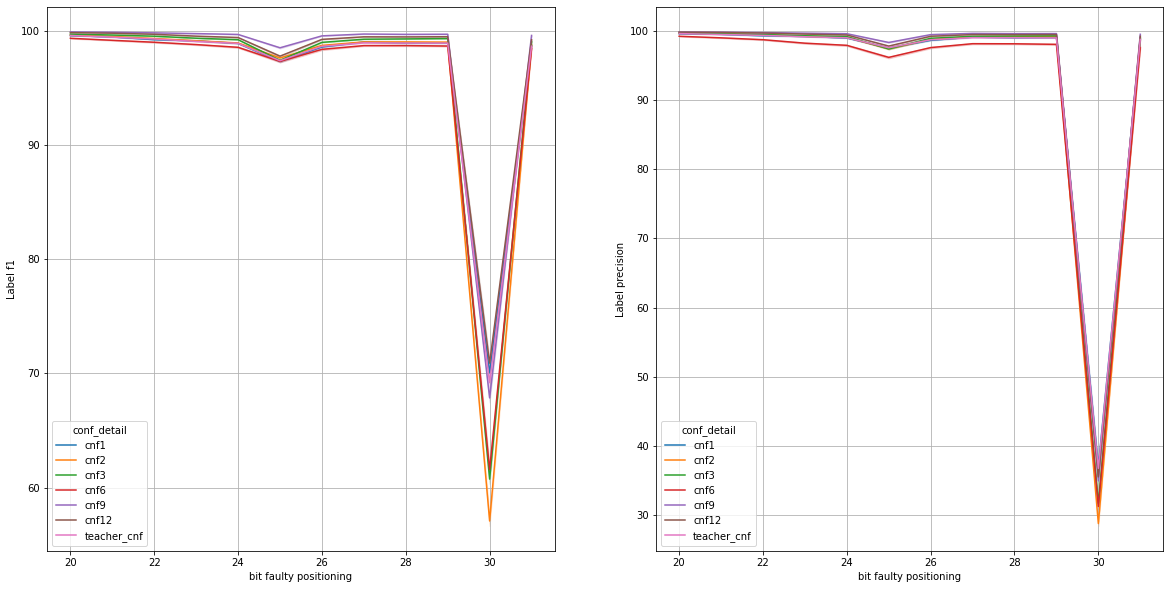

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
# iou_faulty = detailed_report.query("f_class_iou < 100")
ax[0].grid()
# ax[0].legend()
ax[0].set_xlabel('bit faulty positioning')
ax[0].set_ylabel('Label f1')
# sns.move_legend(loc='upper right')
sns.lineplot(data = detailed_report, x= 'bit_faulty_position', y='f_label_f1', hue='conf_detail', ax=ax[0], palette="tab10")
ax[1].grid()
# ax[1].legend()
ax[1].set_xlabel('bit faulty positioning')
ax[1].set_ylabel('Label precision')
# sns.move_legend(loc='upper right')
sns.lineplot(data = detailed_report, x= 'bit_faulty_position', y='f_label_acc', hue='conf_detail', ax=ax[1], palette="tab10")

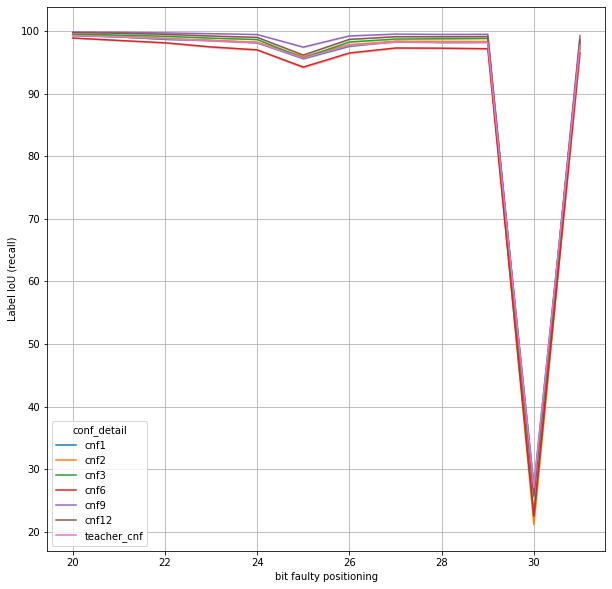

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# iou_faulty = detailed_report.query("f_class_iou < 100")
ax.grid()
# ax.legend()
ax.set_xlabel('bit faulty positioning')
ax.set_ylabel('Label IoU (recall)')
sns.lineplot(data = detailed_report, x= 'bit_faulty_position', y='f_class_iou', hue='conf_detail', ax=ax, palette="tab10")